## Conhecendo os dados

In [1]:
import pandas as pd

In [2]:
dados = pd.read_csv('dados_inadimplencia.csv')
dados.head()

,receita_cliente,anuidade_emprestimo,anos_casa_propria,telefone_trab,avaliacao_cidade,score_1,score_2,score_3,score_social,troca_telefone,inadimplente
0,16855.246324,2997.000000,12.157324,0,2.0,0.501213,0.003109,0.513171,0.117428,243.0,1
1,13500.000000,2776.050000,12.157324,0,2.0,0.501213,0.269730,0.513171,0.097900,617.0,0
2,11250.000000,2722.188351,12.157324,0,3.0,0.701396,0.518625,0.700184,0.118600,9.0,0
3,27000.000000,6750.000000,3.000000,0,2.0,0.501213,0.649571,0.513171,0.047400,300.0,0
4,22500.000000,3097.800000,12.157324,0,2.0,0.440744,0.509677,0.513171,0.014400,2913.0,1


In [3]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14578 entries, 0 to 14577
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   receita_cliente      14578 non-null  float64
 1   anuidade_emprestimo  14578 non-null  float64
 2   anos_casa_propria    14578 non-null  float64
 3   telefone_trab        14578 non-null  int64  
 4   avaliacao_cidade     14578 non-null  float64
 5   score_1              14578 non-null  float64
 6   score_2              14578 non-null  float64
 7   score_3              14578 non-null  float64
 8   score_social         14578 non-null  float64
 9   troca_telefone       14578 non-null  float64
 10  inadimplente         14578 non-null  int64  
dtypes: float64(9), int64(2)
memory usage: 1.2 MB


In [4]:
round(dados['inadimplente'].value_counts(normalize=True)*100, 2)

inadimplente
0    67.65
1    32.35
Name: proportion, dtype: float64

In [5]:
x = dados.drop('inadimplente', axis=1)
y = dados['inadimplente']

In [6]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.33, random_state=RANDOM_STATE, stratify=y)

## Construindo os modelos

### Decision tree classifier

In [7]:
from sklearn.tree import DecisionTreeClassifier

In [8]:
modelo_dt = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE)
modelo_dt.fit(x_treino, y_treino)

DecisionTreeClassifier(max_depth=3, random_state=42)

O recall (também conhecido como taxa de verdadeiros positivos) mede a capacidade do modelo de identificar corretamente todos os casos positivos, ou seja, quantos dos verdadeiros positivos ele conseguiu capturar em relação ao total de casos positivos.

In [9]:
from sklearn.metrics import recall_score

recall_dt = recall_score(y_teste, modelo_dt.predict(x_teste))
print(f"recall do DT = {recall_dt:.3f}")

recall do DT = 0.143


### Regressão logística

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [11]:
logistic_pipeline = make_pipeline(StandardScaler(), LogisticRegression())
logistic_pipeline.fit(x_treino, y_treino)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [12]:
recall_lr = recall_score(y_teste, logistic_pipeline.predict(x_teste))
print(f"recall do LR = {recall_lr:.3f}")

recall do LR = 0.253


## Realizando a busca em grade

### DecisionTreeClassifier

In [13]:
from sklearn.model_selection import GridSearchCV

In [14]:
import numpy as np

param_grid_dt = {
    'criterion':  ['gini', 'entropy'],
    'max_depth': np.linspace(6, 12, 4, dtype=int),
    'min_samples_split': np.linspace(5, 20, 4, dtype=int),
    'min_samples_leaf': np.linspace(5, 20, 4, dtype=int),
    'max_features': ['sqrt', 'log2'],
    'splitter': ['best', 'random']
}

In [15]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(shuffle=True, random_state=RANDOM_STATE)

dt_grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
             param_grid=param_grid_dt,
             scoring="recall",
             n_jobs=-1,
             cv=cv)

dt_grid_search.fit(x_treino, y_treino)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 6,  8, 10, 12]),
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': array([ 5, 10, 15, 20]),
                         'min_samples_split': array([ 5, 10, 15, 20]),
                         'splitter': ['best', 'random']},
             scoring='recall')

### Obtendo informações da busca em grade

In [21]:
dt_grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 12,
 'max_features': 'sqrt',
 'min_samples_leaf': 15,
 'min_samples_split': 5,
 'splitter': 'best'}

In [17]:
df_cv_results_dt = pd.DataFrame(dt_grid_search.cv_results_)
df_cv_results_dt.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.027889,0.007307,0.010919,0.002364,gini,6,sqrt,5,5,best,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.213608,0.145570,0.205696,0.164557,0.200949,0.186076,0.026336,251
1,0.014033,0.001436,0.009081,0.003005,gini,6,sqrt,5,5,random,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.193038,0.132911,0.132911,0.112342,0.161392,0.146519,0.028013,493
2,0.035149,0.011821,0.011084,0.002138,gini,6,sqrt,5,10,best,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.213608,0.145570,0.205696,0.164557,0.200949,0.186076,0.026336,251


In [18]:
df_cv_results_dt.loc[[dt_grid_search.best_index_]]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
208,0.040783,0.008564,0.007591,0.001828,gini,12,sqrt,15,5,best,"{'criterion': 'gini', 'max_depth': 12, 'max_fe...",0.242089,0.324367,0.272152,0.245253,0.232595,0.263291,0.033244,1


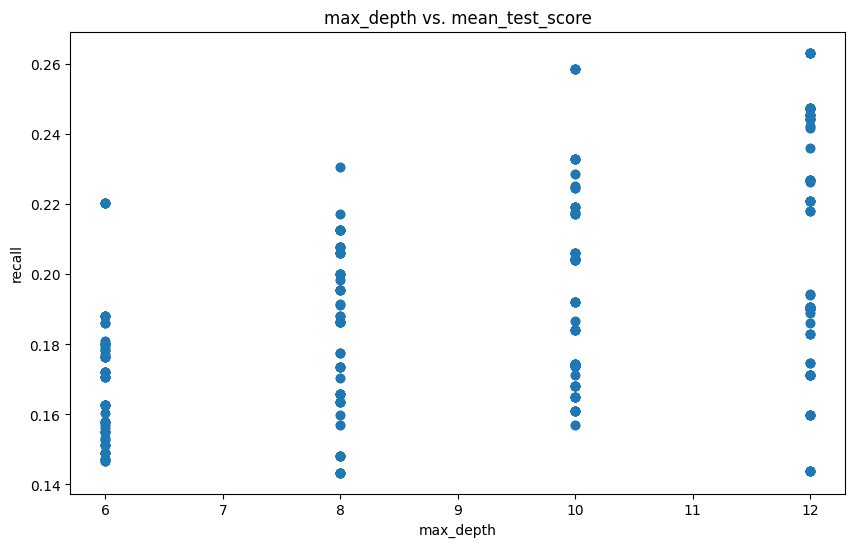

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(
    df_cv_results_dt['param_max_depth'],
    df_cv_results_dt['mean_test_score'],
)

plt.title('max_depth vs. mean_test_score')
plt.xlabel('max_depth')
plt.ylabel('recall')
plt.show()

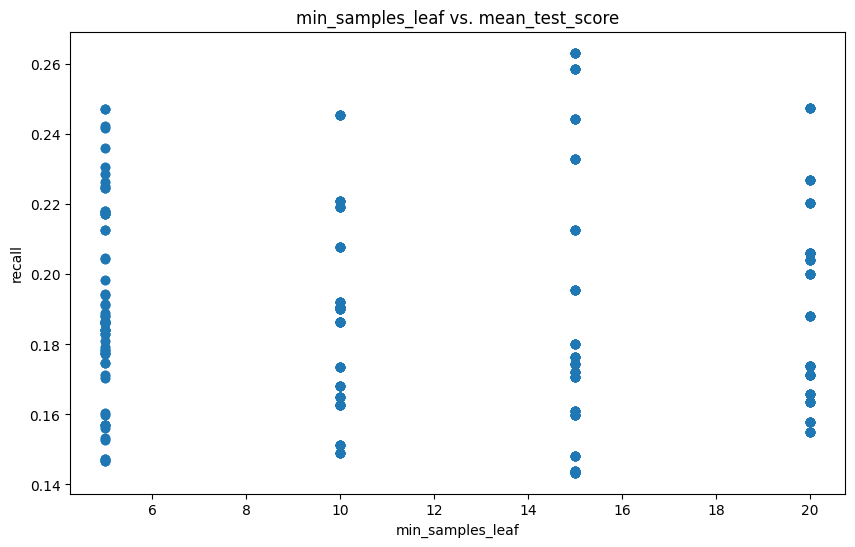

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(
    df_cv_results_dt['param_min_samples_leaf'],
    df_cv_results_dt['mean_test_score'],
)

plt.title('min_samples_leaf vs. mean_test_score')
plt.xlabel('min_samples_leaf')
plt.ylabel('recall')
plt.show()

###  Busca em grade para o LogisticRegression

In [22]:
max_iter = np.linspace(100, 300, 5, dtype=int)
c = [0.001, 0.01, 0.1, 1, 10]

param_grid_lr = [
    {'logisticregression__solver' : ['newton-cg', 'lbfgs'],
      'logisticregression__penalty' : ['l2'],
      'logisticregression__max_iter' : max_iter,
       'logisticregression__C' : c},
    {'logisticregression__solver' : ['liblinear'],
      'logisticregression__penalty' : ['l1', 'l2'],
      'logisticregression__max_iter' : max_iter,
      'logisticregression__C' : c},
]

In [23]:
lr_grid_search = GridSearchCV(estimator=make_pipeline(StandardScaler(), LogisticRegression()),
             param_grid=param_grid_lr,
             scoring="recall",
             n_jobs=-1,
             cv=cv)

lr_grid_search.fit(x_treino, y_treino)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],
                          'logisticregression__max_iter': array([100, 150, 200, 250, 300]),
                          'logisticregression__penalty': ['l2'],
                          'logisticregression__solver': ['newton-cg', 'lbfgs']},
                         {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],
                          'logisticregression__max_iter': array([100, 150, 200, 250, 300]),
                          'logisticregression__penalty': ['l1', 'l2'],
                          'logisticregression__solver': ['liblinear']}],
             scoring='recall')

In [25]:
lr_grid_search.best_params_

{'logisticregression__C': 0.001,
 'logisticregression__max_iter': 100,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'liblinear'}

In [26]:
df_cv_results_lr = pd.DataFrame(lr_grid_search.cv_results_)
df_cv_results_lr.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_logisticregression__max_iter,param_logisticregression__penalty,param_logisticregression__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.094031,0.015284,0.020587,0.007811,0.001,100,l2,newton-cg,"{'logisticregression__C': 0.001, 'logisticregr...",0.102848,0.101266,0.115506,0.088608,0.079114,0.097468,0.012523,86
1,0.061107,0.021054,0.036339,0.015809,0.001,100,l2,lbfgs,"{'logisticregression__C': 0.001, 'logisticregr...",0.102848,0.101266,0.113924,0.087025,0.079114,0.096835,0.012313,91
2,0.224859,0.035364,0.040295,0.027021,0.001,150,l2,newton-cg,"{'logisticregression__C': 0.001, 'logisticregr...",0.102848,0.101266,0.115506,0.088608,0.079114,0.097468,0.012523,86


In [27]:
df_cv_results_lr.loc[[lr_grid_search.best_index_]]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_logisticregression__max_iter,param_logisticregression__penalty,param_logisticregression__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
51,0.07968,0.011477,0.024337,0.008434,0.001,100,l2,liblinear,"{'logisticregression__C': 0.001, 'logisticregr...",0.251582,0.254747,0.265823,0.248418,0.235759,0.251266,0.009723,1


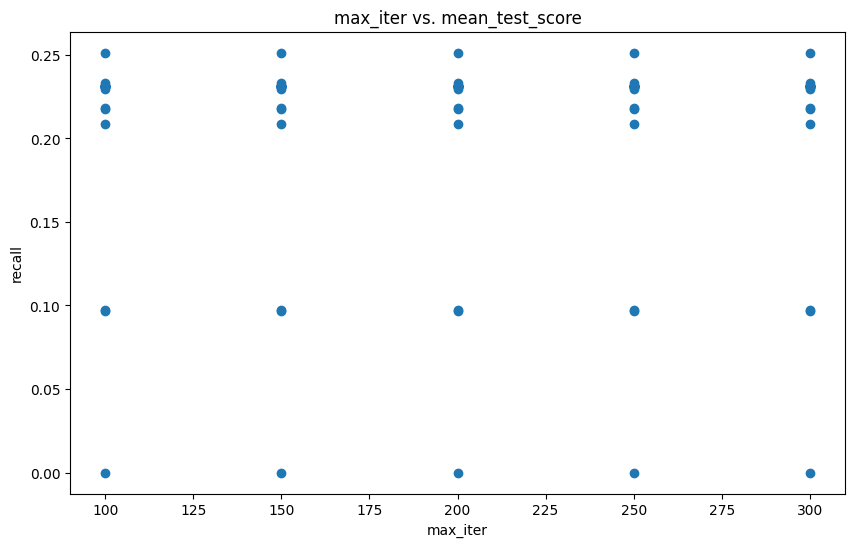

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(
    df_cv_results_lr['param_logisticregression__max_iter'],
    df_cv_results_lr['mean_test_score'],
)

plt.title('max_iter vs. mean_test_score')
plt.xlabel('max_iter')
plt.ylabel('recall')
plt.show()

### Algoritmo KNN

In [29]:
from numpy import linspace
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# Definindo a grade de hiperparâmetros
param_grid_knn = {
    'knn__n_neighbors': linspace(5, 25, 10, dtype=int),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

knn_grid_search = GridSearchCV(estimator = pipe_knn,
                               param_grid = param_grid_knn,
                               scoring = "recall",
                               n_jobs = -1,
                               cv = cv)

knn_grid_search.fit(x_treino, y_treino)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['euclidean', 'manhattan'],
                         'knn__n_neighbors': array([ 5,  7,  9, 11, 13, 16, 18, 20, 22, 25]),
                         'knn__weights': ['uniform', 'distance']},
             scoring='recall')

In [30]:
knn_grid_search.best_params_

{'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}

In [31]:
df_cv_results_knn = pd.DataFrame(knn_grid_search.cv_results_)

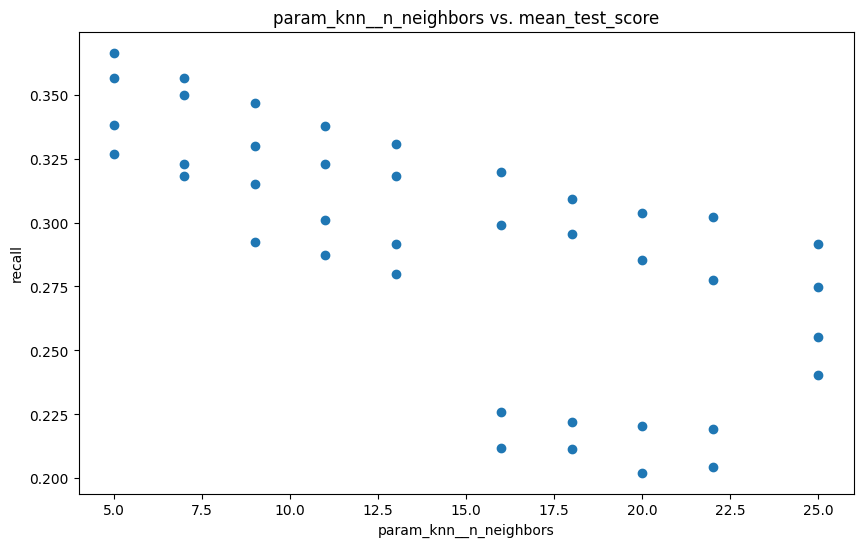

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(
    df_cv_results_knn['param_knn__n_neighbors'],
    df_cv_results_knn['mean_test_score'],
    )

plt.title('param_knn__n_neighbors vs. mean_test_score')
plt.xlabel('param_knn__n_neighbors')
plt.ylabel('recall')
plt.show()

## Validação cruzada aninhada

### Decision Tree Classifier

In [33]:
inner_cv = StratifiedKFold(shuffle=True, random_state=RANDOM_STATE)

outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

In [34]:
from sklearn.model_selection import cross_val_score

dt_nested_gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
             param_grid=param_grid_dt,
             scoring="recall",
             n_jobs=-1,
             cv=inner_cv)

# cross_val_score Validação Cruzada
dt_nested_scores = cross_val_score(dt_nested_gs, x_treino, y_treino, cv=outer_cv)

In [35]:
print(f'resultado de cada iteração do cv externo: {dt_nested_scores}')
print(f'média: {dt_nested_scores.mean()}')

resultado de cada iteração do cv externo: [0.23646724 0.24762808 0.20512821]
média: 0.2297411750289676


### Logistic Regression

In [44]:
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [45]:
max_iter = np.linspace(100, 300, 5, dtype=int)
c = [0.001, 0.01, 0.1, 1, 10]

param_grid_lr = [
    {'logisticregression__solver' : ['newton-cg', 'lbfgs'],
      'logisticregression__penalty' : ['l2'],
      'logisticregression__max_iter' : max_iter,
       'logisticregression__C' : c},
    {'logisticregression__solver' : ['liblinear'],
      'logisticregression__penalty' : ['l1', 'l2'],
      'logisticregression__max_iter' : max_iter,
      'logisticregression__C' : c},
]

In [46]:
lr_nested_gs = GridSearchCV(estimator=make_pipeline(StandardScaler(), LogisticRegression()),
             param_grid=param_grid_lr,
             scoring="recall",
             n_jobs=-1,
             cv=inner_cv)

In [48]:
# cross_val_score Validação Cruzada
lr_nested_scores = cross_val_score(lr_nested_gs, x_treino, y_treino, cv=outer_cv)

In [49]:
print(f'resultado de cada iteração do cv externo: {lr_nested_scores}')
print(f'média: {lr_nested_scores.mean()}')

resultado de cada iteração do cv externo: [0.24691358 0.27703985 0.2374169 ]
média: 0.2537901108426093


In [50]:
lr_nested_gs.fit(x_treino, y_treino)
best_params = lr_nested_gs.best_params_
print("Melhores hiperparâmetros:", best_params)

Melhores hiperparâmetros: {'logisticregression__C': 0.001, 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}


## Busca aleatória

### Decision Tree Classifier

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
rs_dt = RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
                   param_distributions=param_grid_dt,
                   n_iter=100,
                   scoring='recall',
                   n_jobs=-1,
                   cv=inner_cv,
                   random_state=RANDOM_STATE)

rs_dt_nested_scores = cross_val_score(rs_dt, x_treino, y_treino, cv=outer_cv)

In [ ]:
print(f'resultado de cada iteração do cv externo: {rs_dt_nested_scores}')
print(f'média: {rs_dt_nested_scores.mean()}')

resultado de cada iteração do cv externo: [0.23646724 0.18975332 0.21272555]
média: 0.21298203440307595


In [ ]:
rs_dt.fit(x_treino, y_treino)
rs_dt.best_params_

{'splitter': 'best',
 'min_samples_split': 5,
 'min_samples_leaf': 15,
 'max_features': 'sqrt',
 'max_depth': 12,
 'criterion': 'gini'}

### Regressão logística

In [ ]:
rs_lr = RandomizedSearchCV(estimator=make_pipeline(StandardScaler(), LogisticRegression()),
                   param_distributions=param_grid_lr,
                   n_iter=50,
                   scoring='recall',
                   n_jobs=-1,
                   cv=inner_cv,
                   random_state=RANDOM_STATE)

rs_lr_nested_scores = cross_val_score(rs_lr, x_treino, y_treino, cv=outer_cv)

print(f'resultado de cada iteração do cv externo: {rs_lr_nested_scores}')
print(f'média: {rs_lr_nested_scores.mean()}')

resultado de cada iteração do cv externo: [0.24691358 0.27703985 0.2374169 ]
média: 0.2537901108426093


In [ ]:
rs_lr.fit(x_treino, y_treino)
rs_lr.best_params_

{'logisticregression__solver': 'liblinear',
 'logisticregression__penalty': 'l2',
 'logisticregression__max_iter': 150,
 'logisticregression__C': 0.001}

## Otimização Bayesiana

### Decision Tree  Classifier

In [ ]:
!pip install scikit-optimize

In [ ]:
from skopt.space import Real, Integer, Categorical

space_dt = {
    'criterion': Categorical(['gini', 'entropy']),
    'max_depth': Integer(6, 12),
    'min_samples_split': Integer(5, 20),
    'min_samples_leaf': Integer(5, 20),
    'max_features': Categorical(['sqrt', 'log2']),
    'splitter': Categorical(['best', 'random'])
}


In [ ]:
from skopt import BayesSearchCV

In [ ]:
opt_dt = BayesSearchCV(estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
              search_spaces = space_dt,
              n_iter=50,
              scoring='recall',
              n_jobs=-1,
              cv=inner_cv,
              random_state=RANDOM_STATE)

bs_dt_nested_scores = cross_val_score(opt_dt, x_treino, y_treino, cv=outer_cv)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

In [ ]:
print(f'resultado de cada iteração do cv externo: {bs_dt_nested_scores}')
print(f'média: {bs_dt_nested_scores.mean()}')

resultado de cada iteração do cv externo: [0.23646724 0.22011385 0.20512821]
média: 0.2205697645292838


In [ ]:
opt_dt.fit(x_treino, y_treino)
opt_dt.best_params_

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


OrderedDict([('criterion', 'gini'),
             ('max_depth', 12),
             ('max_features', 'log2'),
             ('min_samples_leaf', 15),
             ('min_samples_split', 15),
             ('splitter', 'best')])

### Regressão logística

In [ ]:
max_iter = Integer(100, 300)
c = Categorical([0.001, 0.01, 0.1, 1, 10])

space_lr = [
    {
        'logisticregression__solver' : Categorical(['newton-cg', 'lbfgs']),
        'logisticregression__penalty' : Categorical(['l2']),
        'logisticregression__max_iter' : max_iter,
        'logisticregression__C' : c
    },
    {
        'logisticregression__solver' : Categorical(['liblinear']),
        'logisticregression__penalty' : Categorical(['l1', 'l2']),
        'logisticregression__max_iter' : max_iter,
        'logisticregression__C' : c
    },
]


In [ ]:
opt_lr = BayesSearchCV(estimator=make_pipeline(StandardScaler(), LogisticRegression()),
              search_spaces = space_lr,
              n_iter=50,
              scoring='recall',
              n_jobs=-1,
              cv=inner_cv,
              random_state=RANDOM_STATE)

bs_lr_nested_scores = cross_val_score(opt_lr, x_treino, y_treino, cv=outer_cv)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

In [ ]:
print(f'resultado de cada iteração do cv externo: {bs_lr_nested_scores}')
print(f'média: {bs_lr_nested_scores.mean()}')

resultado de cada iteração do cv externo: [0.24691358 0.27703985 0.2374169 ]
média: 0.2537901108426093


In [ ]:
opt_lr.fit(x_treino, y_treino)
opt_lr.best_params_

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

OrderedDict([('logisticregression__C', 0.001),
             ('logisticregression__max_iter', 150),
             ('logisticregression__penalty', 'l2'),
             ('logisticregression__solver', 'liblinear')])

In [ ]:
opt_lr.predict(x_teste)

array([0, 1, 0, ..., 0, 0, 0])